In [1]:
#det her er den med det gode data
import pandas as pd
from collections import Counter


C:\Users\astri\AppData\Local\Temp\ipykernel_20148\139460001.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_pickle("995,000_rows_preprocessed.pkl")

type
reliable                      218564
political                     194518
bias                          133232
fake                          104883
conspiracy                     97314
rumor                          56445
unknown                        43534
unreliable                     35332
clickbait                      27412
junksci                        14040
satire                         13160
hate                            8779
2018-02-10 13:43:39.521661         1
Name: count, dtype: int64
simple_type
unknown     491121
fake        237529
reliable    218564
Name: count, dtype: int64


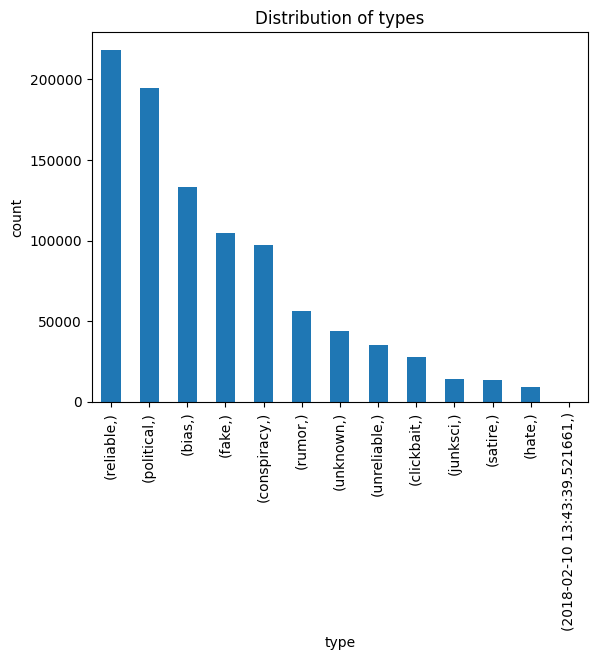

In [ ]:
#træk informations-kategori og content ud i én dataframe
article_type = data['type']
data['type'] = data['type'].astype('category')

fakenews = set(['fake', 'conspiracy'])
#overskydende er reliable, nan og unknown
def label_news(field):
    '''function for labeling news articles as either fake, reliable or unknown'''
    if field in fakenews:
        return 'fake'
    elif field == 'reliable':
        return 'reliable'
    else:
        return 'unknown'

data['simple_type'] = data['type'].apply(lambda x:label_news(x)).astype('category') #laver en ny kolonne med lidt simplere kategorier

print(data['type'].value_counts())
print(data['simple_type'].value_counts())

Exploration uden cleaning

In [ ]:
#More  exploration
import re
year = re.compile(r"201[0-9]")
def get_year(string):
    try:
        match = year.match(string)
        if match:
            return match.group()
    except:
        return 0
print(type(data["scraped_at"]))

print("scraping time statistics:\n", data['scraped_at'].apply(lambda x:get_year(x)).value_counts())
#data["scraped_at"].to_frame().value_counts().plot(kind='bar',ylabel="count",title="Distribution of scraping times",xticks=[])
#dvs de er alle sammen indsamlet i 2018
#obs: det virker ikke muligt at finde ud af præcis hvornår hver enkelt artikel er fra? Det virker vigtigt

<class 'pandas.core.series.Series'>
scraping time statistics:
 scraped_at
2017    647981
2018    308228
2016     38778
0           13
Name: count, dtype: int64


In [ ]:
print("authors:\n", data['authors'].describe())
#data['authors'].to_frame().value_counts().plot(kind='bar',xticks=[])
n = 30
print(data['authors'].value_counts()[:n])

authors:
 count                                                552243
unique                                                99957
top       Backgroundurl Avatar_Large, Nickname, Joined, ...
freq                                                  61398
Name: authors, dtype: object
authors
Backgroundurl Avatar_Large, Nickname, Joined, Created_At, Story Count, N_Stories, Comment Count, N_Comments, Popular Tags, Showtags Popular_Tags    61398
The Associated Press                                                                                                                                 7583
Posted On                                                                                                                                            4510
Truth Broadcast Network                                                                                                                              4462
Александр Артамонов, Руслан Веснянко, Любовь Степушова                                           

In [ ]:
print("\ndomains:\n", data['domain'].describe())
#data['domain'].to_frame().value_counts().plot(kind='bar',ylabel="count",xticks=[],title="Distribution of domains")
#obs: 155 af data kommer fra den samme, og generelt ikke særligt velfordelte kilder
n = 10
print(data['domain'].value_counts()[:n])


domains:
 count          994989
unique            683
top       nytimes.com
freq           176144
Name: domain, dtype: object
domain
nytimes.com           176144
beforeitsnews.com      91468
dailykos.com           77640
express.co.uk          55983
nationalreview.com     37377
sputniknews.com        37229
abovetopsecret.com     27947
wikileaks.org          23699
www.newsmax.com        12688
www.ammoland.com       11129
Name: count, dtype: int64


In [ ]:
#keeping relevant rows
relevant = ['fake','reliable']

data = data[data["simple_type"].isin(relevant) == True] #fjerne ikke-relevante rækker, simple type tracker definitionen af fake news 
print("row count after categorization:", len(data))
print("share of class 1 data points: ", print(len(data[data["simple_type"]=="fake"])/len(data)))

row count after removal: 456093


Exploration post cleaning

In [ ]:
print(data["content"][1][1])
print(data["content"].head())

senat
1    [cost, senat, bank, committe, jp, morgan, buy,...
3    [julia, geist, ask, draw, a, pictur, a, comput...
4    [number, compil, studi, vaccin, danger, activi...
5    [spend, major, wake, hour, stare, content, a, ...
8    [polic, final, left, campus, number, civilian,...
Name: content, dtype: object


In [ ]:
data["length"]=data["content"].apply(lambda x: len(x))
data.groupby('simple_type')['length'].describe()

C:\Users\astri\AppData\Local\Temp\ipykernel_11032\3636226006.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('simple_type')['length'].describe()


,count,mean,std,min,25%,50%,75%,max
simple_type,,,,,,,,
fake,202196.0,212.248422,343.774679,1.0,26.0,105.0,275.0,12417.0
reliable,218564.0,264.269322,296.795110,1.0,84.0,185.0,370.0,14799.0
unknown,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data["length"].describe()

count    420760.000000
mean        239.270705
std         321.285108
min           1.000000
25%          54.000000
50%         148.000000
75%         332.000000
max       14799.000000
Name: length, dtype: float64

In [ ]:
def vocabulary_size(series):
    '''Computes the vocabulary size of a corpus by iterating through every word
    in every document in the corpus and adding it to a dictionary if it hasnt been seen before
    as well as incrementing a variable counting every unique word. Returns the unique_word_count
    and sorted list of words and their frequencies'''
    # Initialize a counter for unique words count and dictionary to store word frequencies
    unique_words_count = 0
    word_frequency = {}
    # Iterate through each element in the series
    for field in series:
        # Iterate through each word in the current element
        for word in field:
            if word in word_frequency: 
                # If word already in dict, increment its count
                word_frequency[word] += 1
            else:
                # If not add it to the dictionary with count 1 and increment unique_words_count
                word_frequency[word] = 1
                unique_words_count += 1
    # Sort the word_frequency dictionary by frequency in descending order
    sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

    return unique_words_count, sorted_word_frequency

def most_frequent(series, from_value, to_value):
    '''returns a dictionary containing the
   "n" most frequent words in an interval - [from_value:to_value] - in the input series.'''
    return dict(vocabulary_size(series)[1][from_value:to_value])

frequent_stemwords = most_frequent(data["content"], 1, 40)

In [ ]:
frequent_stemwords_rel =most_frequent(data[data.simple_type=="reliable"]["content"], 1, 20)
frequent_stemwords_rel

{'number': 1620796,
 'mr': 455876,
 'year': 262772,
 'time': 256874,
 'york': 243603,
 'continu': 242239,
 'stori': 239252,
 'read': 229436,
 'main': 216907,
 'newslett': 205783,
 'state': 178656,
 'sign': 169492,
 'peopl': 164415,
 'work': 150235,
 'advertis': 144779,
 'subscrib': 138575,
 'make': 133254,
 'numbernumb': 130190,
 'compani': 123091,
 'servic': 122219,
 'offer': 115823,
 'day': 110135,
 'product': 107243,
 'receiv': 105468,
 'includ': 104883,
 'presid': 103469,
 'play': 103145,
 'ms': 101749,
 'citi': 99351,
 'view': 98645,
 'american': 97554,
 'percent': 97070,
 'show': 95612,
 'call': 94393,
 'cur00': 93550,
 'email': 90687,
 'photo': 90594,
 'unit': 90179,
 'game': 89922}

In [ ]:
frequent_stemwords_fake = most_frequent(data[data.simple_type=="fake"]["content"], 1, 20)
frequent_stemwords_fake

{'number': 1116047,
 'peopl': 187314,
 'time': 173035,
 'state': 164447,
 'year': 157925,
 'news': 140066,
 'report': 130014,
 'url': 126385,
 'govern': 121975,
 'make': 119991,
 'world': 113663,
 'american': 93489,
 'work': 90210,
 'sourc': 90090,
 'day': 89474,
 'market': 89100,
 'nation': 87888,
 'fact': 84352,
 'stori': 78207,
 'thing': 75213,
 'obama': 73734,
 'call': 73238,
 'read': 72859,
 'presid': 72413,
 'dont': 71731,
 'countri': 70738,
 'numbernumb': 70208,
 'includ': 69131,
 'live': 68181,
 'back': 67704,
 'law': 66100,
 'power': 66040,
 'unit': 65304,
 'inform': 63892,
 'war': 63110,
 'show': 62104,
 'post': 59799,
 'system': 59671,
 'public': 59563}

Baseline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm

#lav numerisk target-vector
def bin_target(x):
    if x=="reliable":
        return 0
    if x=="fake":
        return 1

X = data.drop(["type"],axis=1).drop(["simple_type"],axis=1) #lav x-vector
y = data["simple_type"].apply(lambda x:bin_target(x))#lav target-vector

X_train, X_val, y_train, y_val= train_test_split(X,y,test_size=0.2,random_state=0,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val, test_size=0.5,random_state=0,shuffle=True)
 

In [ ]:
#baseline: logistic regression where x is length of article
X_len_train = pd.DataFrame(X_train["content"].apply(lambda x: len(x))) #get feature with length of article
X_len_val = pd.DataFrame(X_val["content"].apply(lambda x: len(x))) #get X for validation

model = LogisticRegression()
reg = model.fit(X_len_train,y_train)

y_pred = model.predict(X_len_val) #er det test eller validation?
acc = accuracy_score(y_pred,y_val)

print(acc)

0.5997480749120638


In [ ]:
#gridsearch to see if better models with same X exist
def gridSearch(solver,penalties,data,target):
    model = LogisticRegression()
    parameters = {'solver' : solver,'penalty': penalties, 'C' : [0.00001,0.001, 0.01, 0.1, 1.0, 10]}
    clf = GridSearchCV(model, parameters, scoring='accuracy', cv=5)
    clf.fit(data,target)
    return clf

#hvordan kender den svarene på y_val???
articlelen1 = gridSearch(["liblinear"], ["l1","l2"], pd.DataFrame(X_len_train), y_train)
articlelen2 = gridSearch(["newton-cg", "sag","lbfgs"], ["l2","None"],pd.DataFrame(X_len_train), y_train)
articlelen3 = gridSearch(["saga"], ["elastic-net","l1","l2","None"], pd.DataFrame(X_len_train), y_train)

print("results:\n")
baselines = [articlelen1,articlelen2,articlelen3]
for baseline in baselines:
    print(baseline.best_params_, ":\n", "acc =", baseline.best_score_)



c:\Users\astri\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\astri\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\astri\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\astri\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\astri\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\astri\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning:

{'C': 1e-05, 'penalty': 'l2', 'solver': 'liblinear'} :
 acc = 0.6094566943391259
{'C': 1e-05, 'penalty': 'l2', 'solver': 'newton-cg'} :
 acc = 0.6017771425336382
{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'} :
 acc = 0.5271562838069737


In [ ]:
#baseline2: logistic regression, X is number of "fact"-mentions
def word_count_reg(field,word):
    count = 0
    for words in field:
        if words == word:
            count+=1
    return count      

def reg_from_one_word(word):
    X_word_train = pd.DataFrame(X_train["content"].apply(lambda x: word_count_reg(x,word)))
    X_word_val = pd.DataFrame(X_val["content"].apply(lambda x: word_count_reg(x,word)))
    model = LogisticRegression()
    reg = model.fit(X_word_train,y_train)
    y_pred = model.predict(X_word_val)
    return accuracy_score(y_pred,y_val)

print(reg_from_one_word("fact"))

0.6204249453370092
0.5187042494533701
0.5497908546439776
0.5196549101625629
0.5488639604525145
0.5187042494533701


In [ ]:
#check if better model exists
X_fact_train = pd.DataFrame(X_train["content"].apply(lambda x: word_count_reg(x,"fact")))
X_fact_val = pd.DataFrame(X_val["content"].apply(lambda x: word_count_reg(x,"fact")))

fact1 = gridSearch(["liblinear"], ["l1","l2"], pd.DataFrame(X_fact_train), y_train)
fact2 = gridSearch(["newton-cg", "sag","lbfgs"], ["l2","None"],pd.DataFrame(X_fact_train), y_train)
fact3 = gridSearch(["saga"], ["elastic-net","l1","l2","None"], pd.DataFrame(X_fact_train), y_train)

baselines = [fact1,fact2,fact3]
bestscore = 0
bestmodel = articlelen1
for baseline in baselines:
    if baseline.best_score_>bestscore:
        print(bestscore)
        bestscore = baseline.best_score_
        bestmodel = baseline.best_params_

for baseline in baselines:
    print(baseline.best_params_, ":\n", "acc =", baseline.best_score_)


fact1 done


c:\Users\astri\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\astri\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\astri\miniconda3\Lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\astri\miniconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\astri\miniconda3\Lib\site-pac

0
Baseline model is logistic regression with parameters  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
with accuracy: 0.6205675397897681
